In [9]:
# Ucitavanje potrebnih biblioteka

import numpy as np 
import pandas as pd 
import zipfile
import os
import random
import matplotlib.pyplot as plt
import shutil
from tqdm import tqdm 
from skimage.io import imread, imshow
from skimage.transform import resize
from pathlib import Path

from sklearn.metrics import accuracy_score
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Add, Dense, Dropout, Activation, ZeroPadding2D, BatchNormalization, Concatenate, Flatten, Conv2D, AveragePooling2D, MaxPool2D, Reshape, Conv2DTranspose
from keras.optimizers import Adam

import cv2
from sklearn.model_selection import train_test_split 

## Opis problema koji se rešava:
* Detekcija jezgara je poznat i široko rasprostranjen problem u medicini koji ima raznovrsne primene, kao na primer detektovanje kancerogenih ćelija. Iako može delovati kao lak problem, često se dešava da jezgra mogu biti slabo uočljiva (slične nijanse kao pozadina), kao i da se međusobno preklapaju, što ve dovodi do potencijalno teške segmentacije.
* Izabrana baza se sastoji od velikog broja slika jezgara. One su prikupljane u različitim uslovima i razlikuju se po tipu ćelije, vrsti snimanja, veličini jezgara, itd. Sve ove varijacije dobrodošle su radi formiranja modela sposobnog za dobru generalizaciju.
* Priroda problema je segmentacija, a pored samih slika postoje i labele u vidu slika sa već prepoznatim jezgrima. 

## Učitavanje podataka

In [6]:
DATA_DIR = Path() / "Data"
DATA_DIR.mkdir(exist_ok=True, parents=True)
for dirname in Path("/kaggle/input").rglob("*"):
    if "csv" not in dirname.as_posix() and dirname.is_file():
        target = DATA_DIR / dirname.parts[-1][:-4]
        file = zipfile.ZipFile(dirname)
        file.extractall(target)
print("Kraj raspakivanja...")

Kraj raspakivanja...


In [7]:
seed = 42
np.random.seed = seed

# ulazne (predefinisane) dimenzije slike
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

TRAIN_PATH = DATA_DIR / 'stage1_train/'
TEST_PATH = DATA_DIR / 'stage1_test/'

train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [8]:
data = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
labels = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)

for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):   
    path = TRAIN_PATH / id_
    img = imread(path / 'images' / (id_ + '.png'))[:,:,:IMG_CHANNELS]  
    
    # resize-ovanje ucitanih slika i maski na zadatke dimenzije
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    
    data[n] = img
    
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)
    for mask_file in next(os.walk(path / 'masks'))[2]:
        
        mask_ = imread(path / 'masks' / mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)  
            
    labels[n] = mask   

 12%|█▏        | 79/670 [00:33<04:09,  2.37it/s]

KeyboardInterrupt



## Prikaz odbiraka i njihova analiza

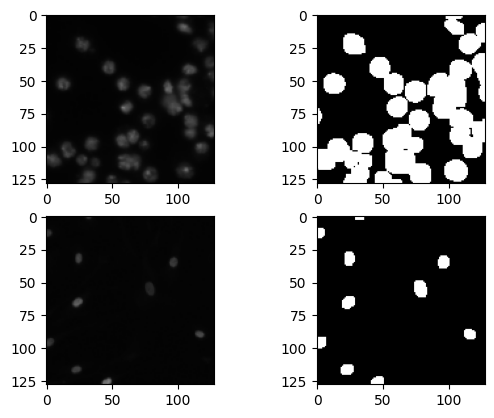

In [7]:
plt.figure()
plt.subplot(2,2,1)
plt.imshow(data[0])
plt.subplot(2,2,2)
plt.imshow(labels[0], cmap = 'gray')
plt.subplot(2,2,3)
plt.imshow(data[1])
plt.subplot(2,2,4)
plt.imshow(labels[1], cmap = 'gray')
plt.show()

Na slici iznad su prikazana dva primera slika nukleusa i njihovih odgovarajućih maski (labela). Na ovim primerima možemo uočiti razlike u veličini, uočljivosti i broju nukleusa.      
Kako ne postoji određena klasa kojoj slika pripada, upoređivani su pojedinačni pikseli (da li pripadaju pozadini ili jezgrima).

In [8]:
sum_nuclei = 0  # broj piksela koji pripada nukleusima 
for image in labels:
    sum_nuclei += np.sum(image)

total = labels.shape[0]*labels.shape[1]*labels.shape[2]
# broj piksela koji pripada pozadini
sum_back = total - sum_nuclei

print("Udeo jezgara:", sum_nuclei/total*100,'%')
print("Udeo pozadine:", sum_back/total*100,'%')

Udeo jezgara: 24.812121035447763 %
Udeo pozadine: 75.18787896455224 %


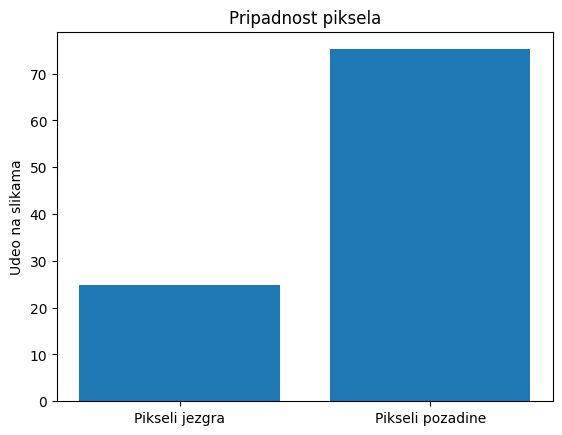

In [34]:
plt.figure()
plt.bar(['Pikseli jezgra','Pikseli pozadine'], [sum_nuclei/total*100, sum_back/total*100])
plt.title('Pripadnost piksela')
plt.ylabel('Udeo na slikama')
plt.show()

Primećuje se da ukoliko bi se svaki piksel klasifikovao na "pripada jezgru" i "pripada pozadini", posmatrali bismo dve klase. Udeo jezgara je 25%, a pozadine 75%, što nije balansirano. Svakako, ovakva raspodela podataka je bila očekivana, zato što se na slikama većinom detektuje par jezgara, koji i zauzimaju manji deo slike. Kako problematika nije klasifikacija, neće biti potrebno izostavljanje neke od klasa. 

## Podela baze na trening, test i validacioni set

Podela odbiraka jedan je od ključnih koraka pre klasifikacije. Obučavanje i testiranje našeg modela velikim delom zavisi od podataka na kojima uči, tako da je potrebno podeliti ih poštujući određena pravila:
1. U trening i test skupu podataka ne smeju postojati isti odbirci, da bismo prilikom testiranja dobili jasniju predstavu o tome koliko naš model dobro generalizuje i da li je došlo do preobučavanja.
2. Prilikom podele podataka potrebno je promešati ih, jer određeni poredak može dovesti do prvobitnog učenja mreže nad jednim tipom podataka, pa tek onda nad drugim, što može dovesti do neadekvatnih rezultata.
3. Uobičajene proporcije pri podeli podataka su 20% za test set, a zatim se ostatak deli po proporciji - 70% trening i  30% validacioni set. Pošto je procenjeno da će što više odbiraka biti potrebno za treniranje modela, u ovom slučaju je 10% podataka uzeto za test set, a 90% ostatka za trening (10% ostatka za validacioni set).
4. Validacioni set nam je neophodan kako bismo proveravali ispravnost obučavanja našeg modela i donosili zaključke o problemima koji se mogu javiti.

In [9]:
X_train, X_test, Y_train, Y_test = train_test_split(data, labels, test_size=0.1, random_state=42, shuffle=True)

In [10]:
X_train.shape, X_test.shape, (X_train.shape[0] + X_test.shape[0])

((603, 128, 128, 3), (67, 128, 128, 3), 670)

Ukupno imamo 670 odbiraka, od kojih se 603 nalazi u trening i 67 u test setu. Kod ulaza u mrežu vrši se izdvajanje validacionog seta koji iznosi 10% trening podataka.

## Predprocesiranje baze
U ovom koraku prethodna obrada nije potrebna. Jedina izmena je primenjena pri samom učitavanju slika, gde su sve one resize-ovane na istu dimenziju 128x128x3, kao i odgovarajuće maske na dimenziju 128x128.


# U-Net mreža

Za arhitekturu mreže izabrana je dobro poznata U-Net mreža:   
      
          
          
<img src="https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png" width="800">

U-Net je standardna konvoluciona neuronska mreža sa enkoder-dekoder tipom arhitekture. Prvobitno je predložena za segmentaciju biomedicinskih slika, a danas predstavlja state of the art algoritam za segmentaciju.

Mreža se sastoji od dva glavna dela - putanje sažimanja (contracting path) i putanje ekspanzije (expansive path). 
 - Putanju sažimanja čini ponavljanje bloka od po 2 konvoluciona sloja (sa 3x3 kernelima, batch normalizacijom i ReLU aktivacionom funkcijom) praćeni max-pooling slojem (sa korakom 2) radi smanjenja dimenzija (downsampling). Nakon svakog max-pool sloja, broj primenjenih filtara se duplira.
 - Putanju ekspanzije čine slojevi za povećanje dimenzija (upsampling) praćeni 2x2 konvolucijom (koja duplo smanjuje broj kanala) i dva konvoluciona sloja sa istim karakteristikma kao i u putanji sažimanja.
 
Takođe, koriste se i skip konekcije koje povezuju slojeve od enkodera i dekodera. One omogućavaju mreži da prikupi i lokalne i globalne prostorne karakteristike.

Zanimljivo je primetiti i da mreža nema potpuno povezane slojeve. Ovako se omogućava rad sa slikama neograničenih dimenzija i omogućava očuvanje korisnih karakteristika u različitim zadacima segmentacije. 

In [10]:
def Conv2DBlock(inputs, num_filters):
    x = Conv2D(num_filters, kernel_size=3, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(num_filters, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
                        
    return x

In [11]:
def EncoderMiniBlock(inputs, num_filters=32):
    
    x = Conv2DBlock(inputs, num_filters)
    p = MaxPool2D((2, 2))(x)
    
    return x, p
    

In [12]:
def DecoderMiniBlock(prev_layer_input, skip_connection_input, num_filters=32):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(prev_layer_input)
    x = Concatenate()([x, skip_connection_input])
    x = Conv2DBlock(x, num_filters)

    return x
    

Arhitektura mreže:

In [13]:
def UNetModel(input_shape, lr = 0.01):
    inputs = Input(input_shape)

    s1, p1 = EncoderMiniBlock(inputs, 64)
    s2, p2 = EncoderMiniBlock(p1, 128)
    s3, p3 = EncoderMiniBlock(p2, 256)
    s4, p4 = EncoderMiniBlock(p3, 512)

    b1 = Conv2DBlock(p4, 1024)

    d1 = DecoderMiniBlock(b1, s4, 512)
    d2 = DecoderMiniBlock(d1, s3, 256)
    d3 = DecoderMiniBlock(d2, s2, 128)
    d4 = DecoderMiniBlock(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    modelUnet = Model(inputs=inputs, outputs=outputs, name="OriginalUNET")

    optimizer = Adam(learning_rate = lr)
    modelUnet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return modelUnet

In [14]:
modelUNet = UNetModel((128, 128, 3), 0.01)
modelUNet.summary()

Model: "OriginalUNET"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 128, 128, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 128, 128, 64)         0         ['batch_normalizati

Obučavanje mreže:

In [53]:
modelUNet = UNetModel((128, 128, 3), 0.01)
callbacks=[tf.keras.callbacks.EarlyStopping(patience=2, monitor="val_loss")]
results = modelUNet.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=25, callbacks=callbacks)

Epoch 1/25
34/34 [==============================] - 20s 247ms/step - loss: 0.2865 - accuracy: 0.8962 - val_loss: 1370.6873 - val_accuracy: 0.7266
Epoch 2/25
34/34 [==============================] - 8s 229ms/step - loss: 0.1853 - accuracy: 0.9304 - val_loss: 14.2039 - val_accuracy: 0.7427
Epoch 3/25
34/34 [==============================] - 8s 230ms/step - loss: 0.1545 - accuracy: 0.9437 - val_loss: 3.0708 - val_accuracy: 0.8599
Epoch 4/25
34/34 [==============================] - 8s 231ms/step - loss: 0.1369 - accuracy: 0.9504 - val_loss: 0.3859 - val_accuracy: 0.8700
Epoch 5/25
34/34 [==============================] - 8s 232ms/step - loss: 0.1254 - accuracy: 0.9529 - val_loss: 0.4029 - val_accuracy: 0.9208
Epoch 6/25
34/34 [==============================] - 8s 233ms/step - loss: 0.1201 - accuracy: 0.9549 - val_loss: 0.1343 - val_accuracy: 0.9540
Epoch 7/25
34/34 [==============================] - 8s 232ms/step - loss: 0.1020 - accuracy: 0.9616 - val_loss: 0.1860 - val_accuracy: 0.9358
E

Testiranje mreže:

In [54]:
Y_pred = np.round(modelUNet.predict(X_test))

3/3 [==============================] - 1s 150ms/step


Prikaz jednog rezultata segmentacije sa labelom:

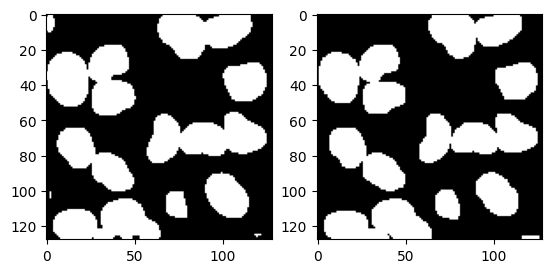

In [133]:
# provera klasifikacije nad jednim odbirkom
plt.figure()
plt.subplot(1,2,1)
plt.imshow(Y_pred[0], cmap = 'gray')
plt.subplot(1,2,2)
plt.imshow(Y_test[0], cmap = 'gray')
plt.show()

Tačnost klasifikacije:

In [56]:
y1 = Y_pred.flatten()
y2 = Y_test.flatten()

accuracy_score(y1, y2)

0.9292493222364738

## Preobučavanje mreže 
je pojam koji definiše nepoželjno ponašanje neuronske mreže (tačnije bilo kog modela mašinskog učenja) kada model daje tačna predviđanja za trening podatke, ali ne i za test set. Model se previše prilagodi na podatke na kojima uči, tako da prikupi previše lokalnih karakteristika, samim tim smanjujući sposobnost generalizacije.

U ovom zadatku izabrana je i implementirana metoda ranog obustavljanja kao metoda za sprečavanje preobučavanja.
- Early Stopping se bazira na praćenju ponašanja validacione greške. Ukoliko mreža krene da se preobučava, loss na trening setu će opadati, ali će suprotno tome na validacionom setu rasti. U trenutku kada primetimo konstantan rast validacionog lossa, prekida se treniranje i čuvaju se performanse najboljeg modela.

## Pronalazak optimalnog parametra obučavanja

Konstanta obučavanja je izabrana kao parametar za ispitivanje. Mreža je trenirana za 4 različite vrednosti i tražena je optimalna vrednost.

In [19]:
learning_rate = [0.0001, 0.001, 0.01, 0.1]
train_val_history = []
Y_pred_all = []

for lr in learning_rate:
    modelUNet = UNetModel((128, 128, 3), lr)
    callbacks = [tf.keras.callbacks.EarlyStopping(patience=2, monitor="val_loss")]
    results = modelUNet.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=25, callbacks=callbacks)
    
    Y_pred = np.round(modelUNet.predict(X_test))
    
    y1 = Y_pred.flatten()
    y2 = Y_test.flatten()
    print('---------------')
    print(accuracy_score(y1, y2))
    print('---------------')
    
    train_val_history.append(results.history)
    Y_pred_all.append(Y_pred)

Epoch 1/25
34/34 [==============================] - 19s 245ms/step - loss: 0.3284 - accuracy: 0.8756 - val_loss: 47.9257 - val_accuracy: 0.3051
Epoch 2/25
34/34 [==============================] - 8s 229ms/step - loss: 0.2330 - accuracy: 0.9163 - val_loss: 47.8628 - val_accuracy: 0.7284
Epoch 3/25
34/34 [==============================] - 8s 231ms/step - loss: 0.1842 - accuracy: 0.9327 - val_loss: 6.0336 - val_accuracy: 0.6772
Epoch 4/25
34/34 [==============================] - 8s 231ms/step - loss: 0.1417 - accuracy: 0.9488 - val_loss: 0.4502 - val_accuracy: 0.8447
Epoch 5/25
34/34 [==============================] - 8s 231ms/step - loss: 0.1253 - accuracy: 0.9540 - val_loss: 0.1982 - val_accuracy: 0.9480
Epoch 6/25
34/34 [==============================] - 8s 231ms/step - loss: 0.1197 - accuracy: 0.9561 - val_loss: 0.1991 - val_accuracy: 0.8809
Epoch 7/25
34/34 [==============================] - 8s 230ms/step - loss: 0.1056 - accuracy: 0.9603 - val_loss: 0.1553 - val_accuracy: 0.9582
Epo

Tokom analize konstante obučavanja, rezultati u vidu trening i validacione tačnosti kao i trening i validacionog lossa za svaku vrednost su sačvani. 

Na graficima ispod, prikazane su performanse svakog od modela (lr = 0.0001, 0.001, 0.01, 0.1).

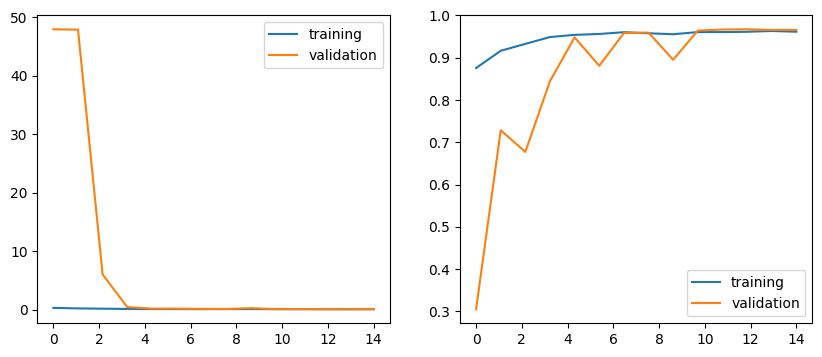

In [20]:
# lr = 0.0001
num = 0
x = len(train_val_history[num]['loss'])

plt.figure(figsize = (10,4))
plt.subplot(1,2,1)
plt.plot(np.linspace(0,x,x), train_val_history[num]['loss'])
plt.plot(np.linspace(0,x,x), train_val_history[num]['val_loss'])
plt.legend(['training', 'validation'])
plt.subplot(1,2,2)
plt.plot(np.linspace(0,x,x), train_val_history[num]['accuracy'])
plt.plot(np.linspace(0,x,x), train_val_history[num]['val_accuracy'])
plt.legend(['training', 'validation'])
plt.show()

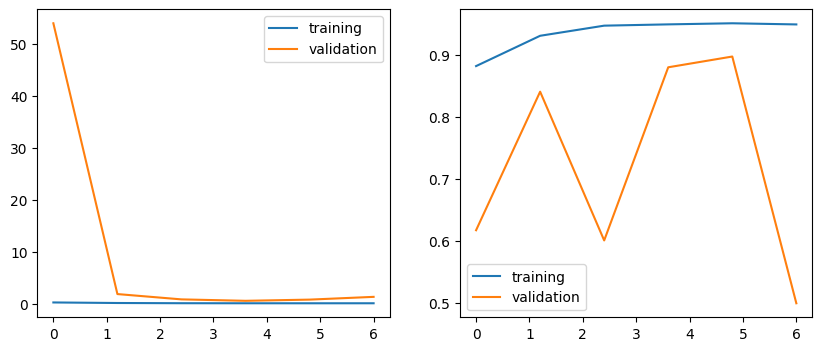

In [21]:
# lr = 0.001
num = 1
x = len(train_val_history[num]['loss'])

plt.figure(figsize = (10,4))
plt.subplot(1,2,1)
plt.plot(np.linspace(0,x,x), train_val_history[num]['loss'])
plt.plot(np.linspace(0,x,x), train_val_history[num]['val_loss'])
plt.legend(['training', 'validation'])
plt.subplot(1,2,2)
plt.plot(np.linspace(0,x,x), train_val_history[num]['accuracy'])
plt.plot(np.linspace(0,x,x), train_val_history[num]['val_accuracy'])
plt.legend(['training', 'validation'])
plt.show()

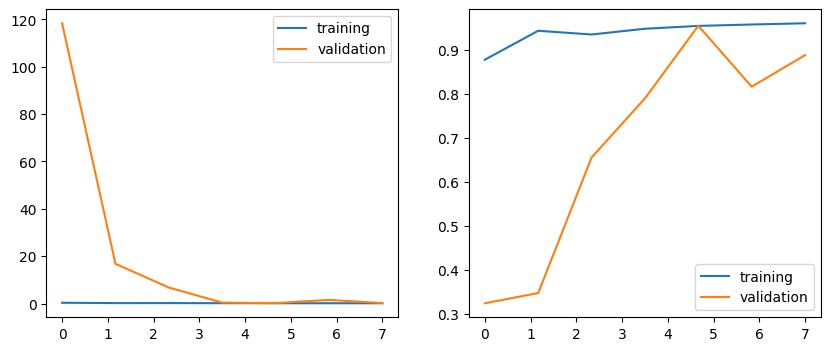

In [22]:
# lr = 0.01
num = 2
x = len(train_val_history[num]['loss'])

plt.figure(figsize = (10,4))
plt.subplot(1,2,1)
plt.plot(np.linspace(0,x,x), train_val_history[num]['loss'])
plt.plot(np.linspace(0,x,x), train_val_history[num]['val_loss'])
plt.legend(['training', 'validation'])
plt.subplot(1,2,2)
plt.plot(np.linspace(0,x,x), train_val_history[num]['accuracy'])
plt.plot(np.linspace(0,x,x), train_val_history[num]['val_accuracy'])
plt.legend(['training', 'validation'])
plt.show()

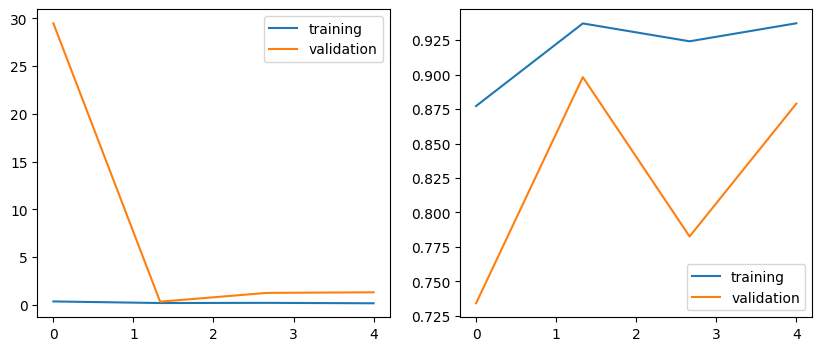

In [23]:
# lr = 0.1
num = 3
x = len(train_val_history[num]['loss'])

plt.figure(figsize = (10,4))
plt.subplot(1,2,1)
plt.plot(np.linspace(0,x,x), train_val_history[num]['loss'])
plt.plot(np.linspace(0,x,x), train_val_history[num]['val_loss'])
plt.legend(['training', 'validation'])
plt.subplot(1,2,2)
plt.plot(np.linspace(0,x,x), train_val_history[num]['accuracy'])
plt.plot(np.linspace(0,x,x), train_val_history[num]['val_accuracy'])
plt.legend(['training', 'validation'])
plt.show()

Iz posmatranih grafika se zaključuje da je optimalna vrednost konstante obučavanja 0.0001. Pad lossa je za prva tri parametra relativno konstantan, dok tačnost dosta osciluje kod poslednja tri parametra. Najmanja oscilovanja i najkonzistentniji rast uočavamo za parametar 0.0001.

## Matrica konfuzije
Kako je problematika ovog projekta segmentacija, nije moguće prikazati rezultate matricom konfuzije jer ne postoje klase. 

Jedino je moguće prikazati matricu konfuzije na nivou klasifikacije pojedinačnih piksela (npr. TP - pikseli koji pripadaju jezgru i tako su i prepoznati).

U kontekstu ove problematike, matrica konfuzije nam ne pruža korisne informacije, pa je nije potrebno analizirati.

## Primeri dobre i loše klasifikacije 

In [59]:
Y_best_model = Y_pred_all[0] # izbor rezultata najboljeg modela

Pronalazak dobrih i loših primera.

In [109]:
diff = []
for image_iter in range(len(Y_best_model)):
    diff.append(abs(np.sum(Y_best_model[image_iter])-np.sum(Y_test[image_iter])))
print(np.where(diff > max(diff) - 900))
print(np.where(diff < min(diff) + 15))

(array([ 7, 14, 51]),)
(array([ 0,  8, 16]),)


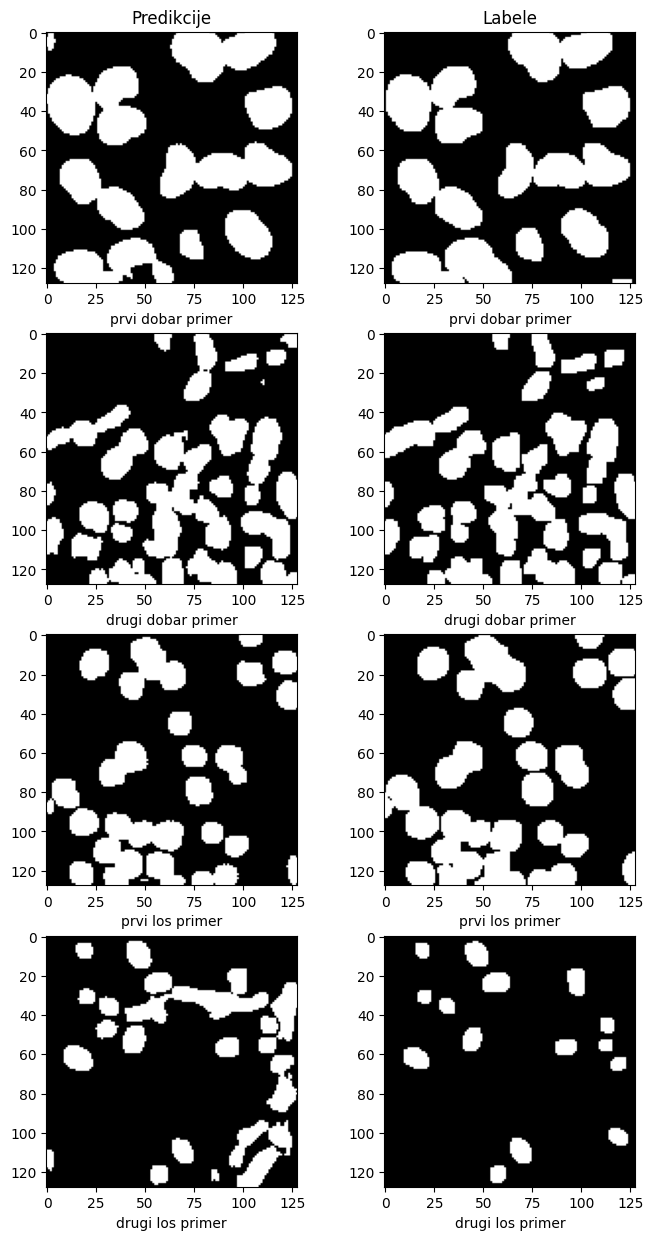

In [131]:
plt.figure(figsize = (8,15))
plt.subplot(4,2,1)
plt.imshow(Y_best_model[0], cmap = 'gray')
plt.title('Predikcije')
plt.xlabel('prvi dobar primer')
plt.subplot(4,2,2)
plt.imshow(Y_test[0], cmap = 'gray')
plt.title('Labele')
plt.xlabel('prvi dobar primer')
plt.subplot(4,2,3)
plt.imshow(Y_best_model[8], cmap = 'gray')
plt.xlabel('drugi dobar primer')
plt.subplot(4,2,4)
plt.imshow(Y_test[8], cmap = 'gray')
plt.xlabel('drugi dobar primer')
plt.subplot(4,2,5)
plt.imshow(Y_best_model[7], cmap = 'gray')
plt.xlabel('prvi los primer')
plt.subplot(4,2,6)
plt.imshow(Y_test[7], cmap = 'gray')
plt.xlabel('prvi los primer')
plt.subplot(4,2,7)
plt.imshow(Y_best_model[14], cmap = 'gray')
plt.xlabel('drugi los primer')
plt.subplot(4,2,8)
plt.imshow(Y_test[14], cmap = 'gray')
plt.xlabel('drugi los primer')
plt.show()

Na slikama gore, prikazani su primeri dobro i loše segmentiranih jezgara (po dva datim redom).  

Na prvom i drugom (dobrim) primerima se opažaju blage razlike kod dodira različitih jezgara, dok se na trećem i četvrtom primeru (lošima) javlja dosta lažno-pozitivnih piksela.